# DSCI 100 Group Project Final Report

## Introduction 

The Pacific Laboratory for Artificial Intelligence (PLAI) set up a MineCraft server where they observed player gameplay, creating a dataset consisting of two files: `players.csv` and `sessions.csv`, which hosts player information and information about played sessions.

Using the `players.csv` dataset, we want to explore which "kinds" of players are most likely to contribute a large amount of data. More specifically, we want to see if a **player's subscription status, age, gender, and experience can predict their playtime.**

Below, we load in data and describe both datasets.

In [ ]:
# Load libraries needed
library(tidyverse)
library(repr)
library(tidymodels)

# Load datasets
players <- read_csv("https://raw.githubusercontent.com/nesteagle/DSCI100-Project/refs/heads/main/data/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/nesteagle/DSCI100-Project/refs/heads/main/data/sessions.csv")

# Rename columns for consistency
players <- players |>
    rename(age = Age, hashed_email = hashedEmail) |>
    drop_na()
sessions <- sessions |>
    rename(hashed_email = hashedEmail) |>
    drop_na()

In [ ]:
# we generate summary statistics using summary()
summary(players)
summary(sessions)

# to get the number of variables and observations
nrow(players)
nrow(sessions)
ncol(players)
ncol(sessions)

# To view the levels of player experience and gender
players |> distinct(experience, gender)

### **Data Description**

#### **players.csv**
- A list that contains the information of all the players. 
- Number of variables (columns): **7**
- Number of observations (rows): **196**

#### Variables:
**experience:** 
- A categorical variable of type character: "Beginner", "Amateur", "Regular", "Veteran", "Pro".
- Refers to the player's surveyed/self-declared experience with Minecraft.
- Collected by survey.

**subscribe:** 
- A categorical variable of type logical (``true`` or ``false``)
- Refers to whether player is subscribed to a game-related newsletter or not.
- 144 TRUE and 52 FALSE
- Collected by survey.

**hashedEmail:** 
- A categorical variable of type character representing the player's hashed email.
- Presumably collected by signup.
  
**played_hours:** A quantitative variable of type double representing the amount of hours they played on the server, collected by playtime logs.
    - Summary statitistics:

| Min | Q1  | Median | Mean | Q3 | Max | NA's|
|-----|-----|--------|------|----|-----|-----|
| 0.00|0.00|0.10|5.85|0.60|223.10|0|

**name:** 
- A categorical variable of type character representing the player's name
- Collected by survey

**gender:** 
- A categorical variable of type character representing the player's self-identified gender:  "Male", "Female", "Non-binary", "Two-Spirited", "Agender", "Prefers not to say", "Other
- Collected by survey


**age:** 
- A quantitative variable of type double representing the player's age
- Collected by survey.
    - Summary statistics:

| Min | Q1  | Median | Mean | Q3 | Max | NA's|
|-----|-----|--------|------|----|-----|-----|
| 9.00|17.00|19.00|21.14|22.75|58.00|2|



#### **sessions.csv**
- A list of individual play sessions by each player
- Number of variables (columns): **5**
- Number of observations (rows): **1535**

#### Variables:
**hashedEmail** 
- A categorical variable of type character
- Represents the session's players' email
- Presumably collected by signup.

**start_time** 
- A categorical/ordinal variable of type character
- Represents the player's session start time (dd/mm/yyy, 24 hour time)
- Collected by server logs

**end_time** 
- A categorical/ordinal variable of type character
- Represents the player's session end time (dd/mm/yyy, 24 hour time)
- Collected by server logs

**original_start_time:** 
- A quantitative variable of type double
- Represents the session's start time recorded in UNIX time (ms since Jan 1, 1970 at 00:00:00 UTC)
- Collected by server logs.
    - Summary statistics:

| Min | Q1  | Median | Mean | Q3 | Max | NA's|
|-----|-----|--------|------|----|-----|-----|
| 1.71e+12|1.72e+12|1.72e+12|1.72e+12|1.72e+12|1.73e+12|0|

**original_end_time:** 
- A quantitative variable of type double
- Represents the session's end time recorded in UNIX time (ms since Jan 1, 1970 at 00:00:00 UTC)
- Collected by server logs.
    - Summary statistics:

| Min | Q1  | Median | Mean | Q3 | Max | NA's|
|-----|-----|--------|------|----|-----|-----|
|1.71e+12|1.72e+12|1.72e+12|1.72e+12|1.72e+12|1.72e+12|2|


#### **Potential Issues in Data**

- Low player count (196) might not be enough to generate meaningful conclusions
- A few NA variables in age and subscribe and original_end_time
- Summary statistics for original_start_time and original_end_time are not too specific as they are rounded to 2 decimal places.


## Exploratory Data Visualization
Here, we load in RColorBrewer for better visualization. We then perform a log(x+1) transform on our players set, so that we're able to see otherwise undefined values of 0. This shift is accounted for through use of custom labels and allows for values of 0 to be plotted (otherwise log(0) is undefined).

In [3]:
# load in color library and set plot width/height
library(RColorBrewer)
options(repr.plot.width = 12, repr.plot.height = 8)
# shift all played hours by 1 for our log(x+1) transform
players_shifted <- players |> 
    mutate(played_hours = played_hours + 1)

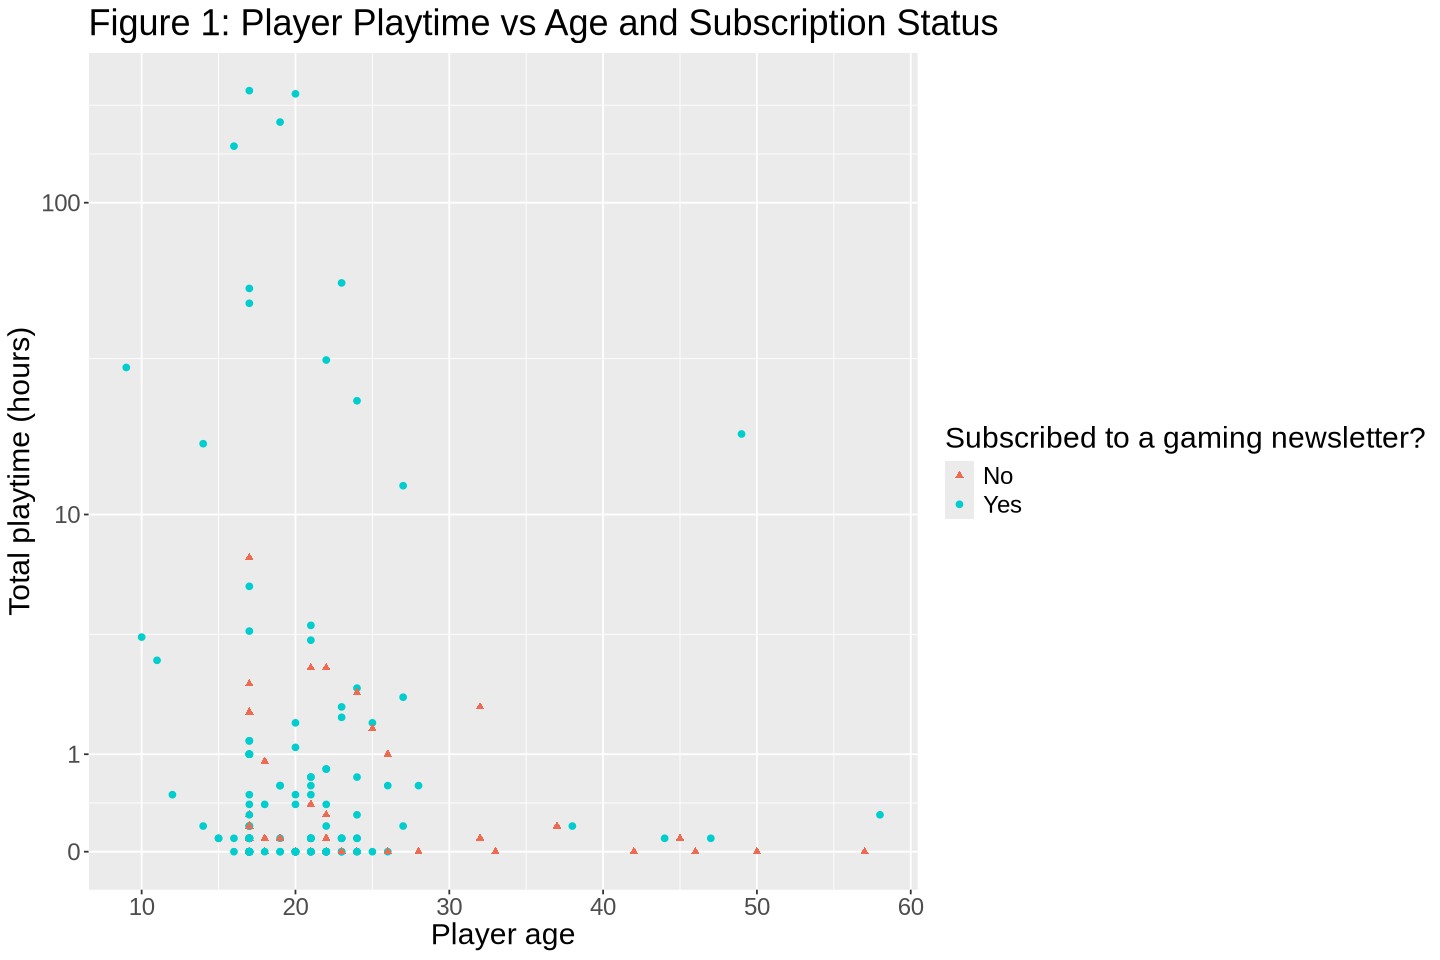

In [4]:
# note use of custom breaks and labels in scale_y_log10
ggplot(players_shifted, aes(x=age, y=played_hours, colour = subscribe, shape = subscribe)) +
    geom_point() +
    labs(x="Player age", y="Total playtime (hours)", colour = "Subscribed to a gaming newsletter?", shape = "Subscribed to a gaming newsletter?", title="Figure 1: Player Playtime vs Age and Subscription Status")+
    scale_color_manual(labels=c("No","Yes"), values=c("coral2", "cyan3"))+
    scale_shape_manual(labels=c("No","Yes"), values=c("triangle", "circle"))+
    scale_y_log10(breaks=c(1,2,11,101), labels=c("0","1","10","100"))+
    theme(text = element_text(size=18))

This is a log-transformed scatterplot of player age against playtime. We can see that players below 30 make up most of the sample, tend to have high variability and can play a lot. We also see that subscribed players have a way higher chance of playing more than players who aren't.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


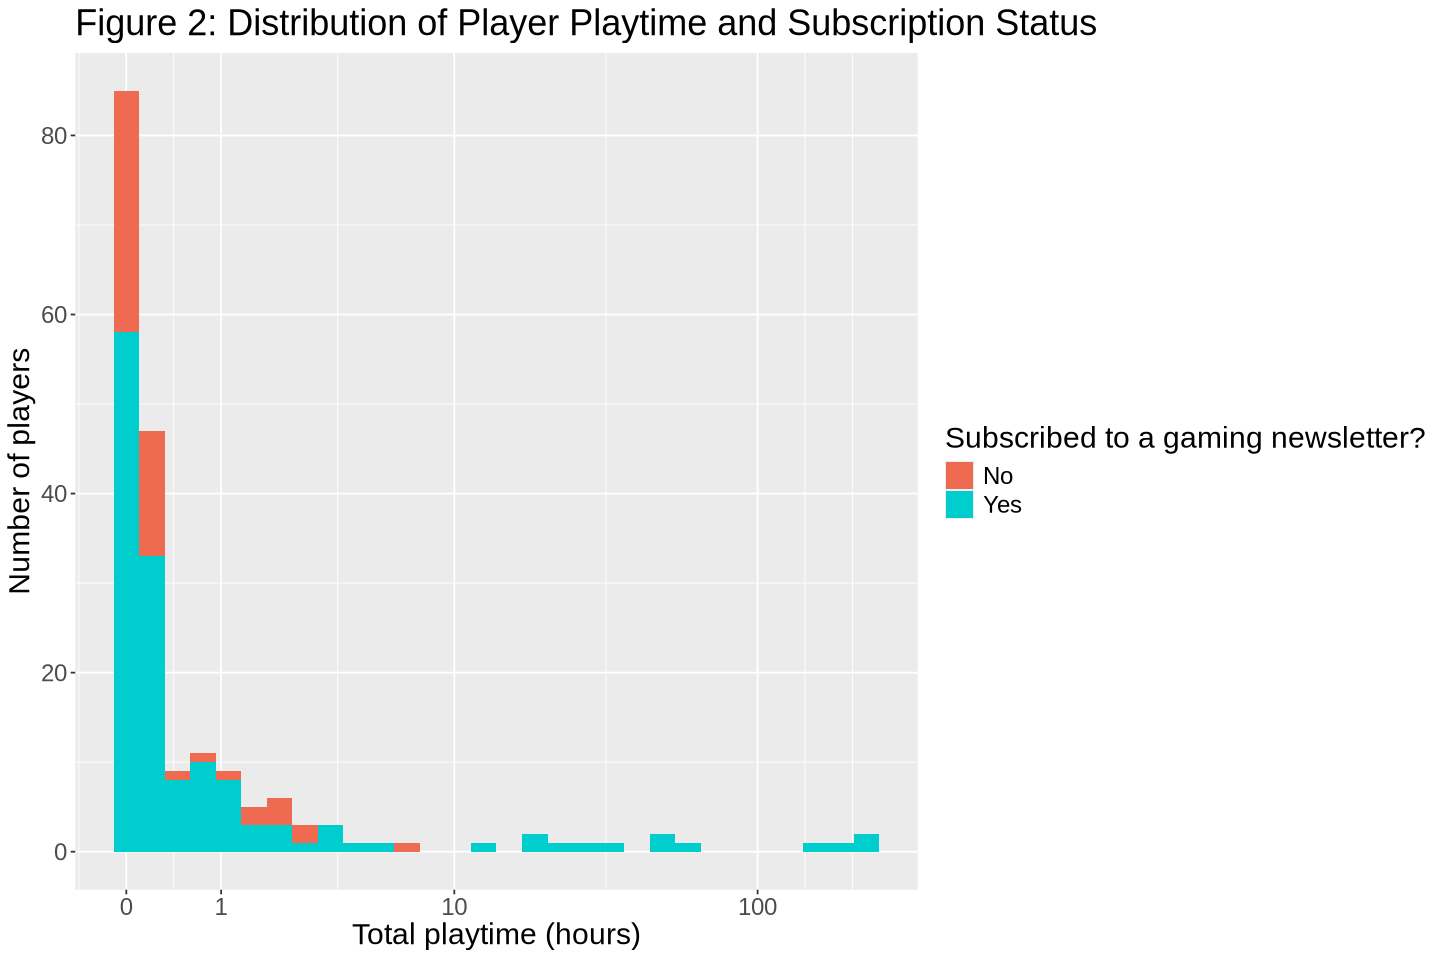

In [5]:
ggplot(players_shifted, aes(x=played_hours, fill = subscribe)) +
    geom_histogram() +
    labs(x="Total playtime (hours)", y="Number of players", fill = "Subscribed to a gaming newsletter?", title="Figure 2: Distribution of Player Playtime and Subscription Status")+
    scale_fill_manual(labels=c("No","Yes"), values=c("coral2", "cyan3"))+
    theme(text = element_text(size=18))+
    scale_x_log10(breaks=c(1,2,11,101), labels=c("0","1","10","100"))

This is a log-transformed histogram of player playtime, with the color representing their subscription status. It is right skewed and from this we can see that most players do not play at all, and contribute very little, but a small minority play a lot.

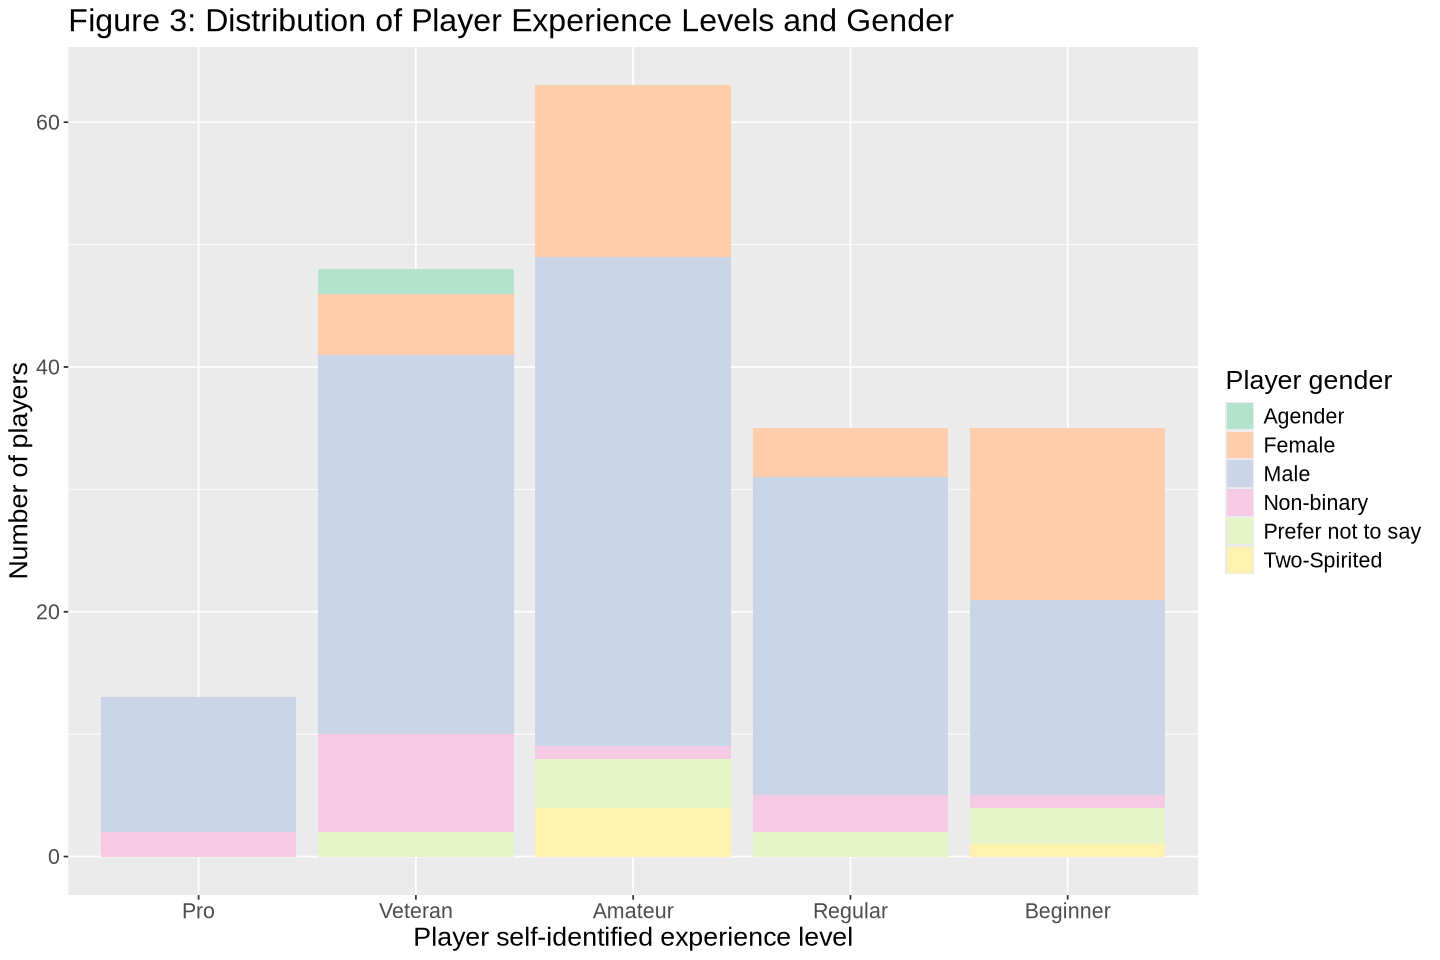

In [6]:
ggplot(players, aes(x=as_factor(experience), fill = gender)) +
    geom_bar(stat="count") +
    theme(text = element_text(size=16)) +
    labs(x="Player self-identified experience level", y="Number of players", title="Figure 3: Distribution of Player Experience Levels and Gender", fill = "Player gender")+
    scale_fill_brewer(palette = 'Pastel2')

This barplot visualizes the distribution of players' self-identified experience levels and gender. We can see that the majority of players are male and female, and that it's most common for players to identify as amateur.

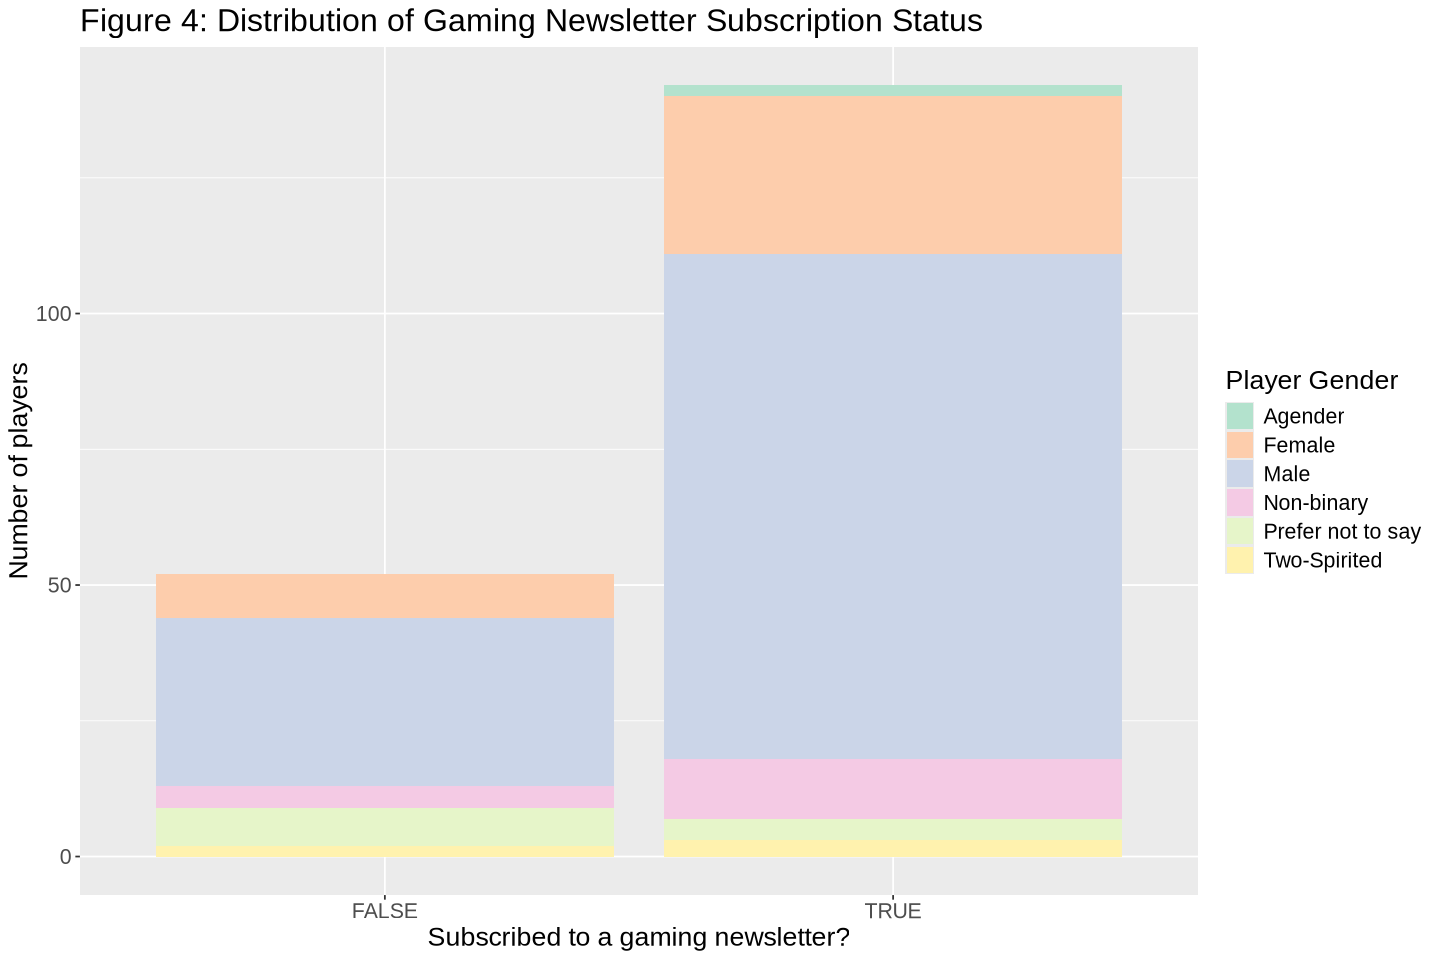

In [7]:
ggplot(players, aes(x=subscribe, fill=gender)) + 
    geom_bar(stat="count") +
    theme(text = element_text(size=16)) +
    labs(x="Subscribed to a gaming newsletter?", y="Number of players", title="Figure 4: Distribution of Gaming Newsletter Subscription Status", fill = "Player Gender")+
    scale_fill_brewer(palette = 'Pastel2')

These barplots compare the gender distributions of subscription status to a gaming newsletter. From this, we see that the majority of players are subscribed to a gaming newsletter.

In [ ]:
# set seed for reproducibility
set.seed(2026)

# turn subscribe logical into factor
players_factor <- mutate(players, subscribe = as_factor(subscribe))

# split into testing, training sets
players_split <- initial_split(players_factor, prop = 0.7, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

# create k-nn recipe with played_hours strata against predictors
players_recipe <- recipe(played_hours ~ subscribe+age+gender+experience, data = players_train) |>
    step_scale(age) |>
    step_center(age)

# create k-nn regression model with neighbor tuning
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# 5-fold cross validation
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

# create workflow using our model and recipe; fit to player data
players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(players_train)

# create k values from 1-50 for comparison
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# collect metrics on predictions using each k
players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") 

Now that we've collected metrics on our model, we can find the best value for neighbors (the entry with the lowest standard error):

In [9]:
# take the entry with lowest standard error:
rmse_min <- players_results |>
    slice_min(std_err, n=1)
rmse_min 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,rmse,standard,31.95368,4,7.764819,Preprocessor1_Model19


And below, we plot our RMSE values per K from 1-50.

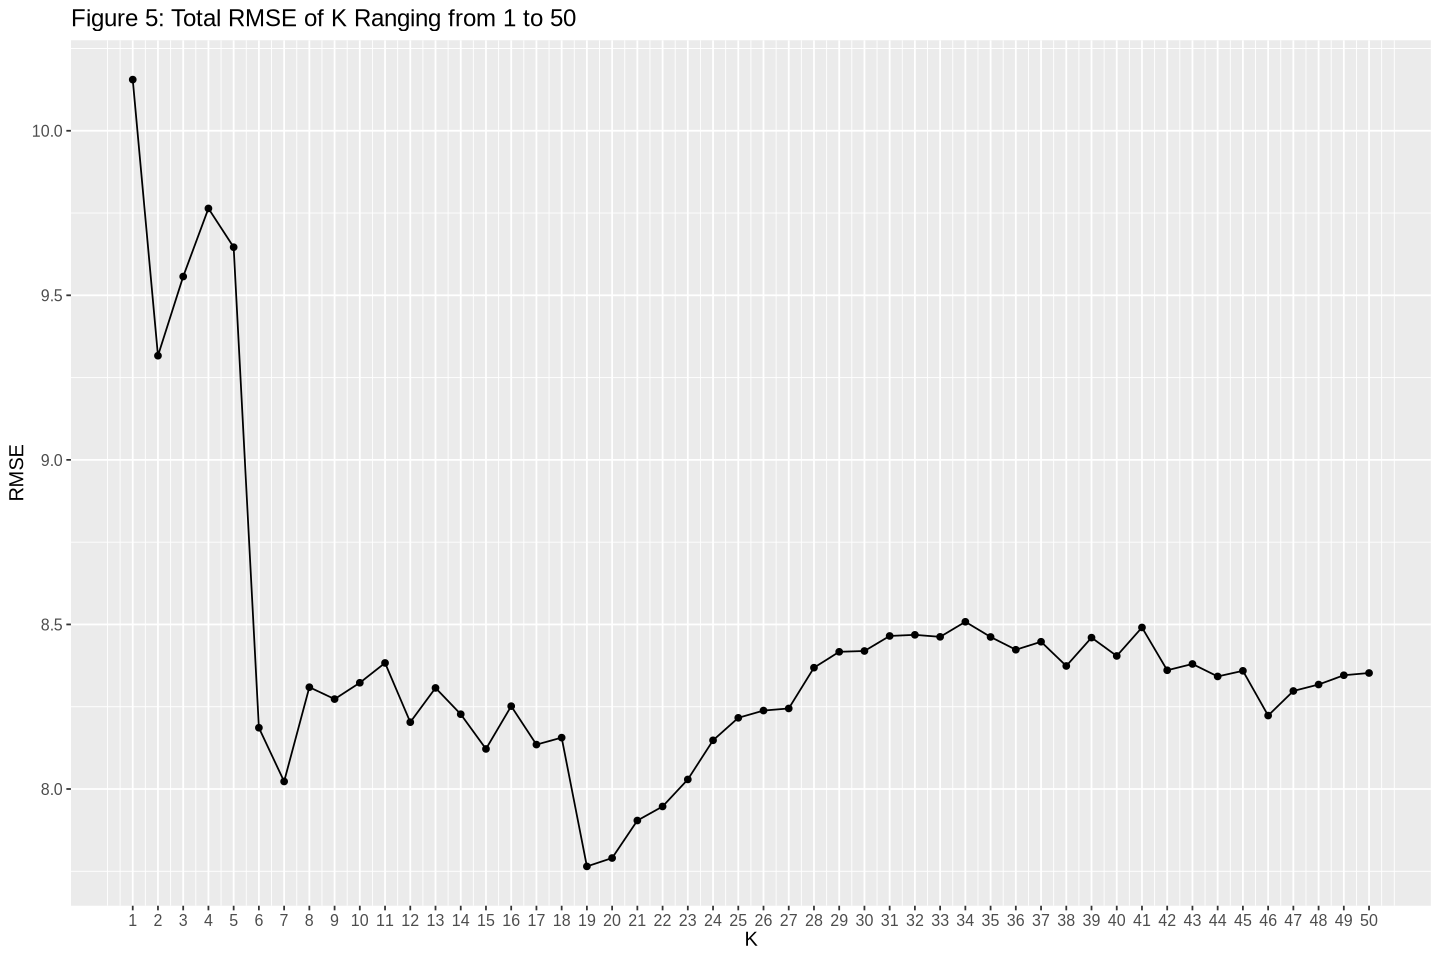

In [10]:
rmse_plot <- players_results |>
    ggplot(aes(x = neighbors, y = std_err)) +
    geom_point() +
    geom_line () +
    labs(x = "K", y = "Standard Error", title = "Figure 5: Total Standard Error of K Ranging from 1 to 50") +
    scale_x_continuous(breaks = 1:50) +
    theme(text = element_text(size = 12))

rmse_plot

From the plot above and previous analysis, we find that the K value with the lowest standard error is $K=19$. Below, we specify a new model using 19 neighbors, predict on training data using it, and plot example predictions with a scatter plot of playtime against age. Note that due to there being 4 predictors, it is hard to effectively visualize.

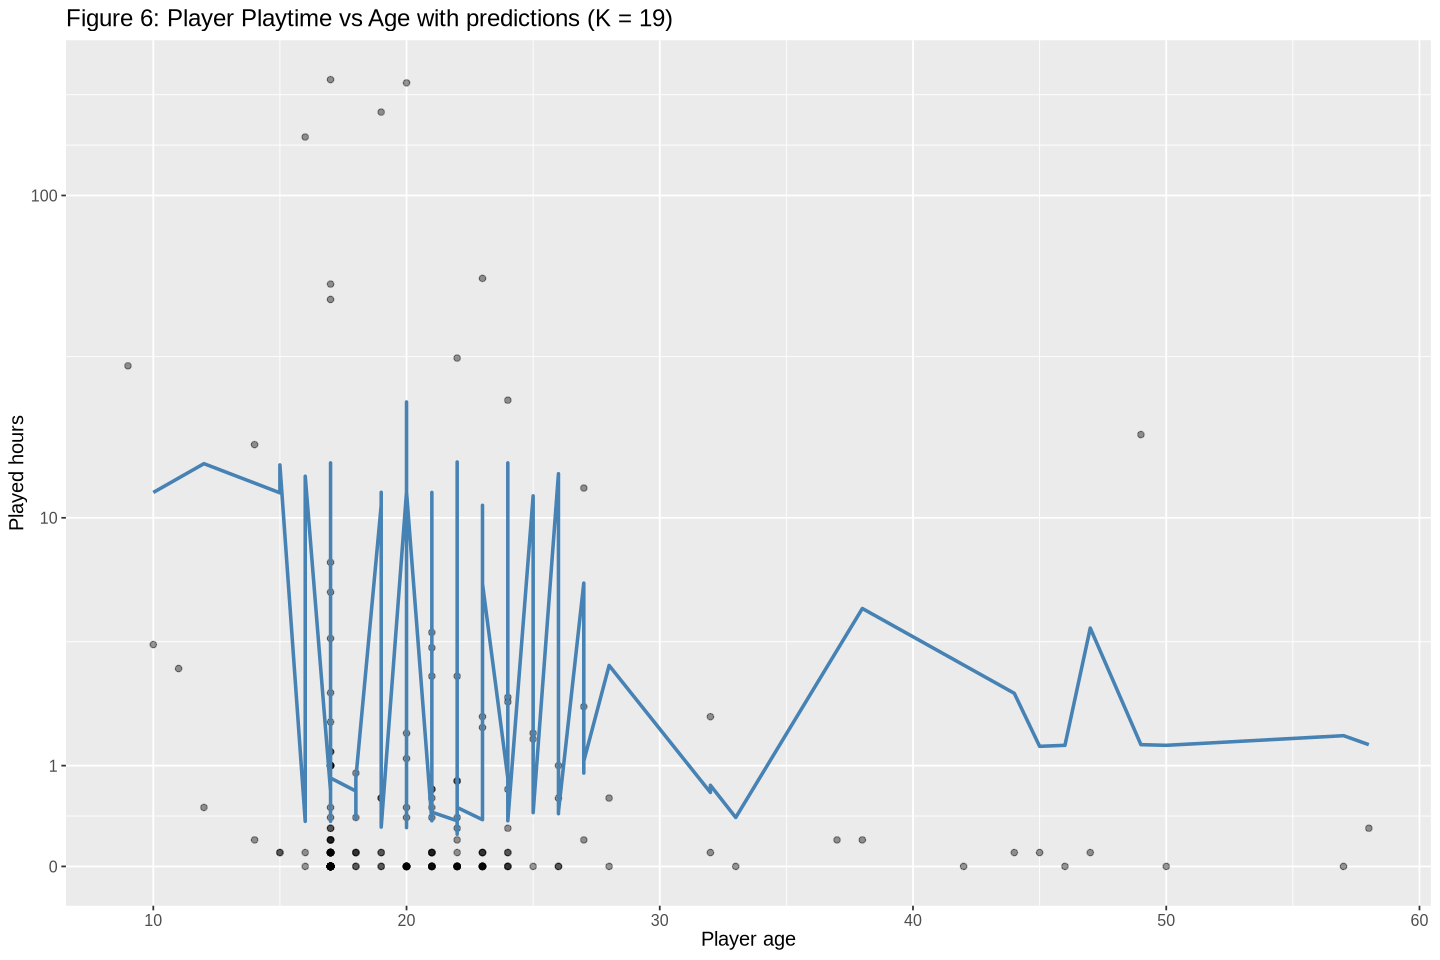

In [17]:
set.seed(2026)

# model with k=19
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("regression")

# workflow with our k=19 model
players_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(players_train)

# example predictions for our line layer on scatterplot
players_preds <- players_best_fit |>
    predict(players_train) |>
    bind_cols(players_train) |>
    mutate(.pred = .pred+1)

# our visualization
plot_final <- ggplot(players_shifted, aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    geom_line(data = players_preds,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    xlab("Player age") +
    ylab("Played hours") +
    scale_y_log10(breaks=c(1,2,11,101), labels=c("0","1","10","100"))+
    ggtitle("Figure 6: Player Playtime vs Age with predictions (K = 19)") +
    theme(text = element_text(size = 12))
plot_final

And finally, we gather the RMSPE on testing data.

In [12]:
# RMSE on testing data
players_summary <- players_best_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric=="rmse")

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,24.04881


## Discussion:
In our project, we found that we could predict players' playtime based on their age, experience, gender and subscription status to a gaming newsletter with a RMSPE of 24.05. This is around what we expected to find, since there isn't a obvious pattern within our data. These findings suggest that younger players who tend to be subscribed to gaming newsletters will play more than older players and those who aren't subscribed.

Future questions this could lead to is:
- Does self-identified experience level have a difference among playtime?
- Are there lurking factors or possibly unexplored relationships that should be found?
- What are other important factors to look for that could have a causal relationship with playtime?